In [1]:
#!/usr/bin/env python3
import os
import re
import sys

import collections
import argparse
import tables
import itertools
import matplotlib
import glob
import math

import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.sparse as sp_sparse
import scanpy as sc 
import scanpy.external as sce

from collections import defaultdict
from scipy import sparse, io

from scipy.sparse import csr_matrix
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## GWAS
____

In [2]:
DATA = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/MB231_GWAS/Singlet_sub_df.h5'
singlet_df = pd.read_hdf(DATA, 'df')

#### adata from 10x 

In [3]:
h5_file = '/project/GCRB/Hon_lab/s426305/Sequencing_data_analysis/10X/YW104-YW109/10x/MB231-YWsg1_combine_nova_new/outs/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(h5_file, gex_only=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata.var_names_make_unique()
adata.raw = adata

In [5]:
singlet_cell_ID = singlet_df.columns

In [6]:
singlet_mtx = adata[singlet_cell_ID]

In [7]:
#use recipe from Zheng et al
sc.pp.recipe_zheng17(singlet_mtx, n_top_genes = 1000)

Trying to set attribute `.var` of view, copying.


### Dimension reduction
___

In [8]:
sc.tl.pca(singlet_mtx)

In [9]:
sc.pp.neighbors(singlet_mtx,
                use_rep='X_pca')

In [10]:
sc.tl.louvain(
    singlet_mtx,
    resolution=0.1)

In [11]:
sc.tl.paga(
    singlet_mtx,
    groups='louvain'
)

/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/project/GCRB/Hon_lab/s426305/Conda/py37-cluster2/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


### UMAP
___

In [12]:
sc.tl.umap(singlet_mtx)

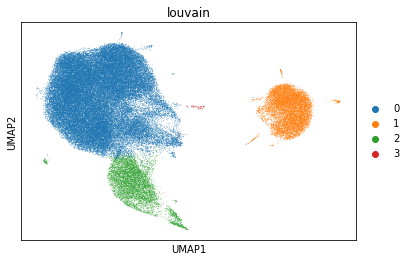

In [13]:
sc.pl.umap(
    singlet_mtx,
    color = ['louvain'])

## DE analysis 
___

In [14]:
#Danny's function
def Get_Gene_Set(data, clustering = 'louvain', cluster = 'All', direction = 'up', pval=0.05):
    if clustering !='louvain' and cluster == 'All':
        print('Must be louvain for All cluster parameter.')
    if cluster == 'All' and clustering == 'louvain':
        for clust in data.obs[clustering].cat.categories:
            pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
            if direction == 'up':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
            elif direction == 'down':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
            with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
                for gene in filtered_genes:
                    f.write(gene + "\n")
    elif cluster != 'Combined' and clustering == 'louvain':
        clust = cluster
        pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
        if direction == 'up':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
        elif direction == 'down':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
        with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
            for gene in filtered_genes:
                f.write(gene + "\n")
    else:
        for sample in data.obs[clustering].cat.categories:
            try:
                pval_genes = data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['pvals_adj'][sample] < pval]
                if direction == 'up':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] > 0]]
                elif direction == 'down':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] < 0]]
                with open(sample + '_' + direction + "_genes.txt", "a") as f:
                    for gene in filtered_genes:
                        f.write(gene + "\n")
            except:
                continue
    return

In [15]:
sc.tl.rank_genes_groups(singlet_mtx,
                        groupby='louvain',
                        method='wilcoxon')

In [16]:
Get_Gene_Set(singlet_mtx)

## Plot sgrna UMAP

In [17]:
DATA = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/MB231_GWAS/Singlet_sgRNA_df.h5'
sgrna_df = pd.read_hdf(DATA, 'df')
total_sgrna = np.sum(sgrna_df > 0, axis=0)

In [18]:
sgrna_dict  = {}
sgrnas_file = '/project/GCRB/Hon_lab/s426305/Analysis/Mosaic-seq/MB231-dCas9-KRAB+YWsg1P3/enhancer_regions_combined.txt'
with open(sgrnas_file) as f:
    for line in f:
        region_id, sgrna_string = line.strip().split("\t")
        sgrnas = sgrna_string.split(";")
        sgrna_dict.update({region_id : sgrnas})

In [21]:
singlet_mtx.obs

,n_counts_all,louvain
CACTAAGAGGGCAGTT-2,7988.0,1
GTTGCTCGTCGACTTA-7,4118.0,0
GGGCTACGTATGGGAC-6,16192.0,0
GGCAGTCAGCGCGTTC-2,6899.0,1
CATTGAGAGGTCACTT-7,14470.0,0
...,...,...
GTCCTCACACCGTGAC-8,5033.0,0
TGTGTGATCCTCTCGA-6,9518.0,0
TTTCACACAGACAATA-4,18386.0,0
CTTGAGAGTGAGTAAT-2,7609.0,1


In [27]:
singlet_mtx.obs['sgrna_num'] = total_sgrna

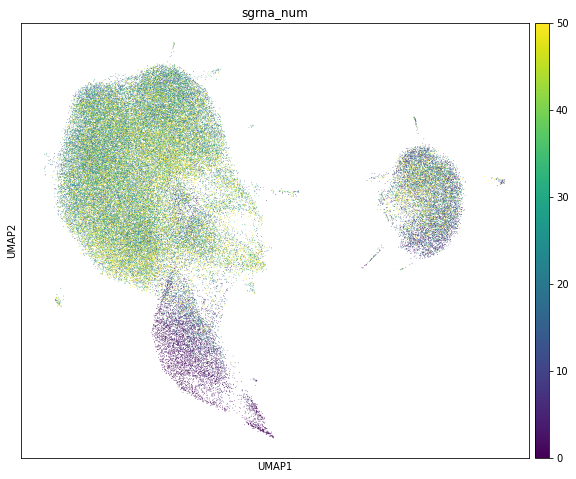

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
          color=['sgrna_num'],
          size=2, 
          vmax=50,
          ax=ax,
          save='MB231_GWAS_sgrna_num.png'
          )

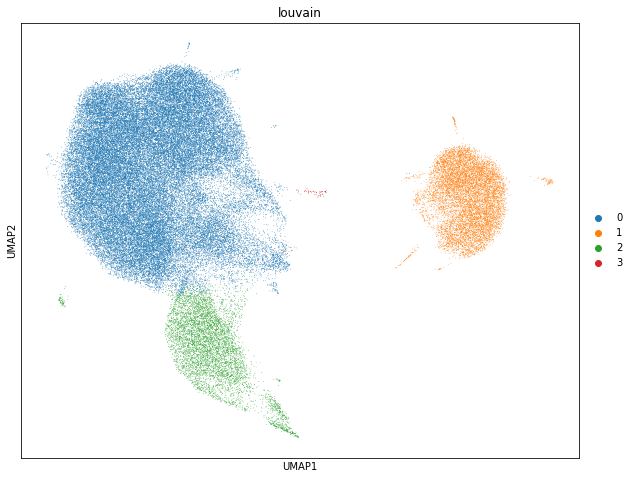

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
          color=['louvain'],
          size=2, 
          ax=ax,
          save='MB231_GWAS_UMAP.png'
          )

## SM
____

In [32]:
DATA = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/MB231_SM/Singlet_sub_df.h5'
singlet_df = pd.read_hdf(DATA, 'df')

#### adata from 10x 

In [33]:
h5_file = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/MB231-SM_combine-1/outs/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(h5_file, gex_only=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [34]:
adata.var_names_make_unique()
adata.raw = adata

In [35]:
singlet_cell_ID = singlet_df.columns

In [36]:
singlet_mtx = adata[singlet_cell_ID]

In [37]:
#use recipe from Zheng et al
sc.pp.recipe_zheng17(singlet_mtx, n_top_genes = 1000)

Trying to set attribute `.var` of view, copying.


### Dimension reduction
___

In [38]:
sc.tl.pca(singlet_mtx)

In [39]:
sc.pp.neighbors(singlet_mtx,
                use_rep='X_pca')

In [48]:
sc.tl.louvain(
    singlet_mtx,
    resolution=0.1)

In [49]:
sc.tl.paga(
    singlet_mtx,
    groups='louvain'
)

### UMAP
___

In [50]:
sc.tl.umap(singlet_mtx)

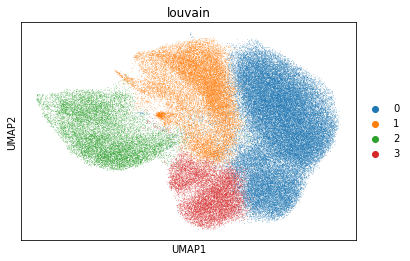

In [51]:
sc.pl.umap(
    singlet_mtx,
    color = ['louvain'])

## DE analysis 
___

In [52]:
#Danny's function
def Get_Gene_Set(data, clustering = 'louvain', cluster = 'All', direction = 'up', pval=0.05):
    if clustering !='louvain' and cluster == 'All':
        print('Must be louvain for All cluster parameter.')
    if cluster == 'All' and clustering == 'louvain':
        for clust in data.obs[clustering].cat.categories:
            pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
            if direction == 'up':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
            elif direction == 'down':
                filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
            with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
                for gene in filtered_genes:
                    f.write(gene + "\n")
    elif cluster != 'Combined' and clustering == 'louvain':
        clust = cluster
        pval_genes = data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['pvals_adj'][clust] < pval]
        if direction == 'up':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] > 0]]
        elif direction == 'down':
            filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][clust][data.uns['rank_genes_groups']['scores'][clust] < 0]]
        with open('Cluster_' + clust + '_' + direction + "_genes.txt", "a") as f:
            for gene in filtered_genes:
                f.write(gene + "\n")
    else:
        for sample in data.obs[clustering].cat.categories:
            try:
                pval_genes = data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['pvals_adj'][sample] < pval]
                if direction == 'up':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] > 0]]
                elif direction == 'down':
                    filtered_genes = [gene for gene in pval_genes if gene in data.uns['rank_genes_groups']['names'][sample][data.uns['rank_genes_groups']['scores'][sample] < 0]]
                with open(sample + '_' + direction + "_genes.txt", "a") as f:
                    for gene in filtered_genes:
                        f.write(gene + "\n")
            except:
                continue
    return

In [53]:
sc.tl.rank_genes_groups(singlet_mtx,
                        groupby='louvain',
                        method='wilcoxon')

In [54]:
Get_Gene_Set(singlet_mtx)

## Plot sgrna UMAP

In [55]:
DATA = '/project/GCRB/Hon_lab/s426305/Analysis/Spade_test/MB231/MB231_SM/Singlet_sgRNA_df.h5'
sgrna_df = pd.read_hdf(DATA, 'df')
total_sgrna = np.sum(sgrna_df > 0, axis=0)

In [56]:
singlet_mtx.obs['sgrna_num'] = total_sgrna

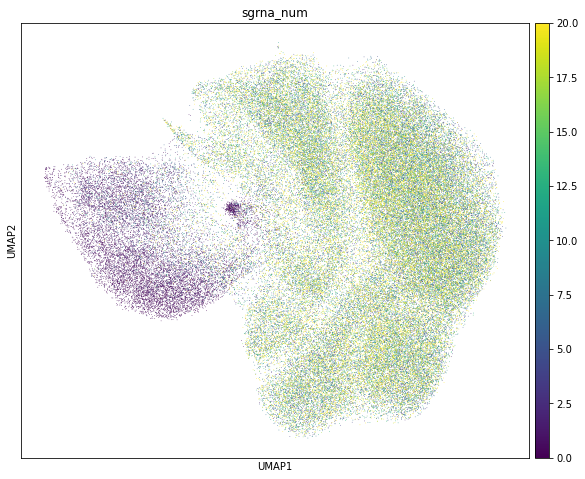

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
          color=['sgrna_num'],
          size=2, 
          vmax=20,
          ax=ax,
          save='MB231_SM_sgrna_num.png'
          )

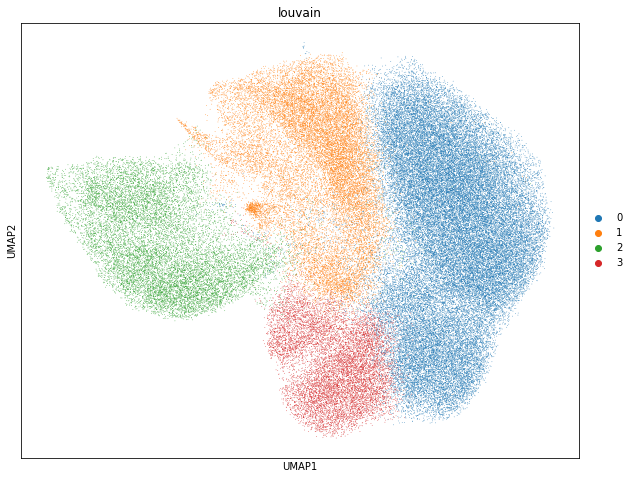

In [60]:
fig, ax = plt.subplots(figsize=(10,8))
sc.pl.umap(singlet_mtx, 
          color=['louvain'],
          size=2, 
          ax=ax,
          save='MB231_SM_UMAP.png'
          )